# Here is an implementation of K-means.
A not very optimized implementation of K-means.

In [1]:
## Imports
import numpy as np
from scipy.spatial.distance import cdist
import pylab as pb
from numpy.random import multivariate_normal as mvnorm
from math import pi
from tqdm import tqdm

In [11]:
## Methods

def generateData(nrData,dimData,nrClusters,sigma=1,meanSpread=10,meanBias=False,diagCov=True):
    #Generates nrData data-points with dimenesion dimData 
    #evenly divided into nrClusters clusters from a 
    #Gaussian normal distribution.
    
    nrPerCluster = int(np.floor(nrData/nrClusters));
    data = np.zeros((nrData,dimData))
    
    for i in range(nrClusters):
        mean, cov = getMeanCov(dimData,sigma,meanSpread,meanBias,diagCov);
        tmpSamples = mvnorm(mean,cov,nrPerCluster);
        data[i*nrPerCluster:(i+1)*nrPerCluster,:] = tmpSamples;

    #adds more data to the last cluster in case nrData%nrClusters != 0
    if(nrData%nrClusters != 0):
        tmpSamples = mvnorm(mean,cov,int(nrData%nrClusters));
        data[-(nrData%nrClusters):,:] = tmpSamples;
        
    return data

def plotGrid(clusterCenters):
    #plots the grid and clusters
    axisMin = np.min(clusterCenters,axis=0);
    axisMax = np.max(clusterCenters,axis=0);
    shift = 20;
    
    xGrid,yGrid = np.meshgrid(np.linspace(axisMin[0]-shift,axisMax[0]+shift,1000),
                              np.linspace(axisMin[1]-shift,axisMax[1]+shift,1000));
    grid = np.array([xGrid,yGrid]).reshape(2,-1).T;
    pb.contourf(xGrid, yGrid, KNNpredict(grid,clusterCenters).reshape(1000, 1000), alpha=0.5);

def getMeanCov(dim,sigma,meanSpread,meanBias,diagCov=True):
    #Generates a mean and covariance matrix at random from a gaussian distr.
    #Returns mean as a 1-D array and diagonal cov as a dim x dim matrix.
    
    if(meanBias):
        rnd = 2*pi*np.random.rand();
        bias = meanSpread*np.array([np.cos(rnd),np.sin(rnd)])
        mean = meanSpread*np.random.randn(dim,)+bias;
    else:
        mean = meanSpread*np.random.randn(dim,);
        
    if(diagCov):
        cov = sigma**2*np.eye(dim);
    else:
        cov = sigma**2*np.random.randn(dim,dim);
        
    return mean, cov

def computeLoss(data,mean):
    #Computes the loss J, data is a matrix with data on each row,
    #rnk is a matrix with a 1 in column k corresponding the the row n's cluster.
    #mean is a matrix with the mean for cluster k on row k
    
    clostestClusters = findClosestCluster(data,mean);
    distance = cdist(data,mean,'sqeuclidean');
    
    J=0;
    for c,j in enumerate(clostestClusters):
        J+=distance[c,j];

    return J;

def findClosestCluster(data,mean):
    #Finds the closest cluster for each datapoint
    distance = cdist(data,mean,'sqeuclidean');
    closestCluster = np.argmin(distance,axis=1);
    
    return closestCluster.reshape(data.shape[0],1)

def getInitialMeanGuesses(nrOfClusters,dim,meanSpread=10):
    #Gets an initial guess of means with 'spread' 10
    means = np.zeros((nrOfClusters,dim))
    
    for i in range(nrOfClusters):
        tmpMean = meanSpread*np.random.randn(1,dim);
        means[i,:] = tmpMean;
        
    return means

def reEstimateMean(data,mean):
    #ReEstimates the mean
    estMean = np.zeros(mean.shape);
    
    #finds closest clusters for the datapoints
    closestCluster = findClosestCluster(data,mean);
    
    #sets the new means
    for i in range(mean.shape[0]):
        ind = closestCluster == i;
        tmpData = data*ind;
        newMean = np.sum(tmpData,axis=0)/(np.sum(ind)+1e-10);
        estMean[i,:] = newMean;
    
    return estMean;
        
def KNN(data,mean,maxIter=100,tolerance=0.00001):
    #Does the KNN algortihm until convergence
    #Returns the centoid means and the loss-vector
    J = computeLoss(data,mean);
    Jlist = np.array([J]);
    
    for i in tqdm(range(maxIter)):
        closestClusters = findClosestCluster(data,mean);
        mean = reEstimateMean(data,mean);
        J = computeLoss(data,mean);
        Jlist = np.append(Jlist,J);
        if(Jlist[-2]/Jlist[-1]<(1+tolerance)):
            print("\nearly stopping\n")
            break;
    
    return mean, Jlist

def KNNpredict(xNew,clusterCenters):
    #Predicts which cluster a new datapoint will belong to, return a number from [0,K-1]
    
    closest = findClosestCluster(xNew,clusterCenters);
        
    return closest

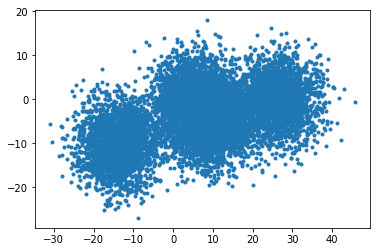

In [16]:
dataPoints = 10000;
dimensions = 2;
clusters = 4;
spread = 10;
data = generateData(dataPoints,dimensions,clusters,meanSpread=spread,sigma=5,meanBias=True)
pb.plot(data[:,0],data[:,1],'.')
pb.show()



 15%|██████████▏                                                         | 15/100 [00:00<00:01, 46.17it/s]


early stopping



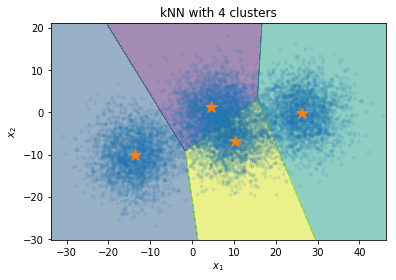

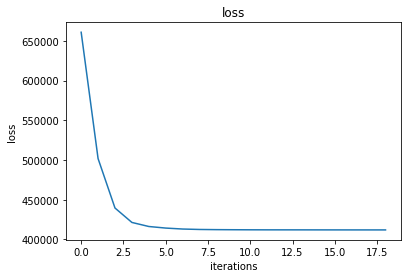

In [17]:
clusters = 4;
dimensions = 2;
meanInit = reEstimateMean(data,getInitialMeanGuesses(clusters,dimensions,meanSpread=15))

newMean,J = KNN(data,meanInit)

pb.plot(data[:,0],data[:,1],'.',alpha=0.1)
pb.plot(newMean[:,0],newMean[:,1],'*',markersize=12)
plotGrid(newMean)
#pb.gca().set_aspect('equal', adjustable='box')
pb.title("kNN with {} clusters".format(clusters))
pb.xlabel("$x_1$")
pb.ylabel("$x_2$")
pb.show()

pb.plot(J)
pb.title("loss")
pb.xlabel("iterations")
pb.ylabel("loss")
pb.show()
